# Variational AutoEncoder

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/03<br>
**Last modified:** 2020/05/03<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Create a sampling layer

In [ ]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs

        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]

        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        print('inputs.shape', inputs.shape)
        print('batch', batch)
        print('dim', dim)
        print('epsilon.shape', epsilon)

        # z_mean + ( e ^ (z_log_var/2) ) * E
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


# Convolution / Deconvolution Process
Sourc: https://www.geeksforgeeks.org/variational-autoencoders/

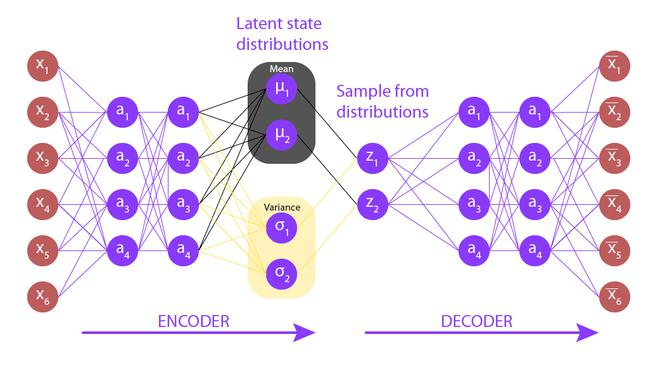

## Build the encoder
See: https://learnopencv.com/variational-autoencoder-in-tensorflow/

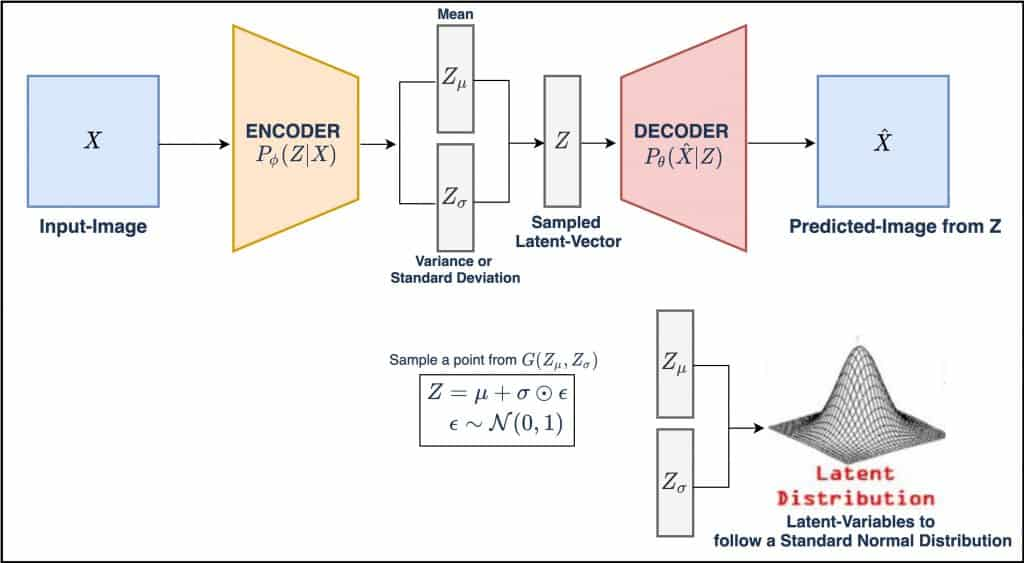

We follow the same steps as in the image

In [ ]:
latent_dim = 2

# 1. define the input shape
encoder_inputs = keras.Input(shape=(28, 28, 1))

# 2. create layers 
# filter size = 32 > Input_shape = 28 => Image will be smaller
conv_layer1 = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
maxpooling_layer = layers.MaxPooling2D(pool_size=(2,2))(conv_layer1)

flatten_layer = layers.Flatten()(maxpooling_layer)
output_layer = layers.Dense(16, activation="relu")(flatten_layer)

# 3. compute z_mean and z_log_var
z_mean = layers.Dense(latent_dim, name="z_mean")(output_layer)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(output_layer)
z = Sampling()([z_mean, z_log_var])

# 4. Initialize the encoder
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# encoder.summary()

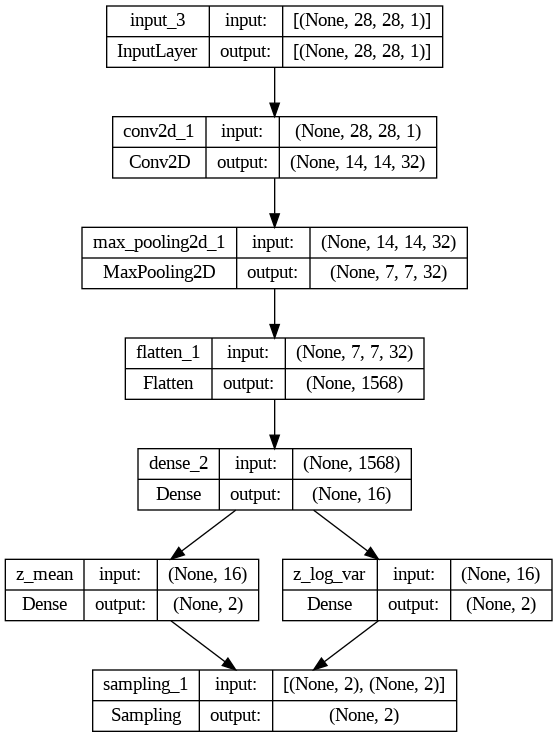

In [ ]:
keras.utils.plot_model(encoder, "encoder.png", show_shapes=True)

## Build the decoder

In [ ]:

latent_inputs = keras.Input(shape=(latent_dim,))

# 1. transposed CNN
output_layer = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
output_layer = layers.Reshape((7, 7, 64))(output_layer)

deconv64 = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(output_layer)
upsampling2 = layers.UpSampling2D( size=(2, 2) )(deconv64)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(upsampling2)

# 2. instantiate the decoder
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

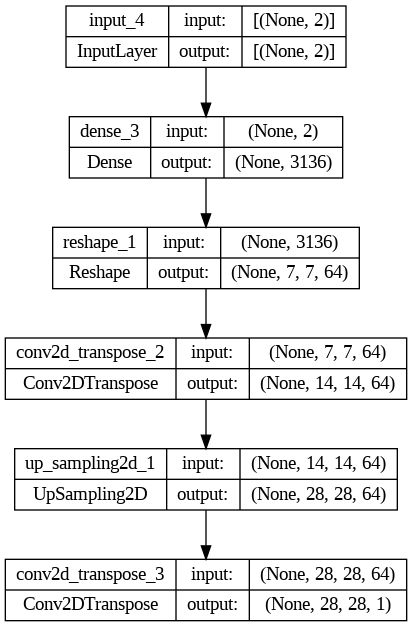

In [ ]:
keras.utils.plot_model(decoder, "decoder.png", show_shapes=True)

In [ ]:
# latent_inputs = keras.Input(shape=(latent_dim,))

# # 1. transposed CNN
# output_layer = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# output_layer = layers.Reshape((7, 7, 64))(output_layer)

# deconv64 = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(output_layer)
# deconv32 = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(deconv64)

# decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(deconv32)

# # 2. instantiate the decoder
# decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
# decoder.summary()

## Define the VAE as a `Model` with a custom `train_step`

In [ ]:

class VAE(keras.Model):
    # init the encoder, decoder and the loss metrics
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


  # encapsulate the metrics to make them read-only
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # give acess to the gradient for backprop computation
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # losses
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train the VAE

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=64)

## Display a grid of sampled digits

1/1 [==============================] - 0s 27ms/step


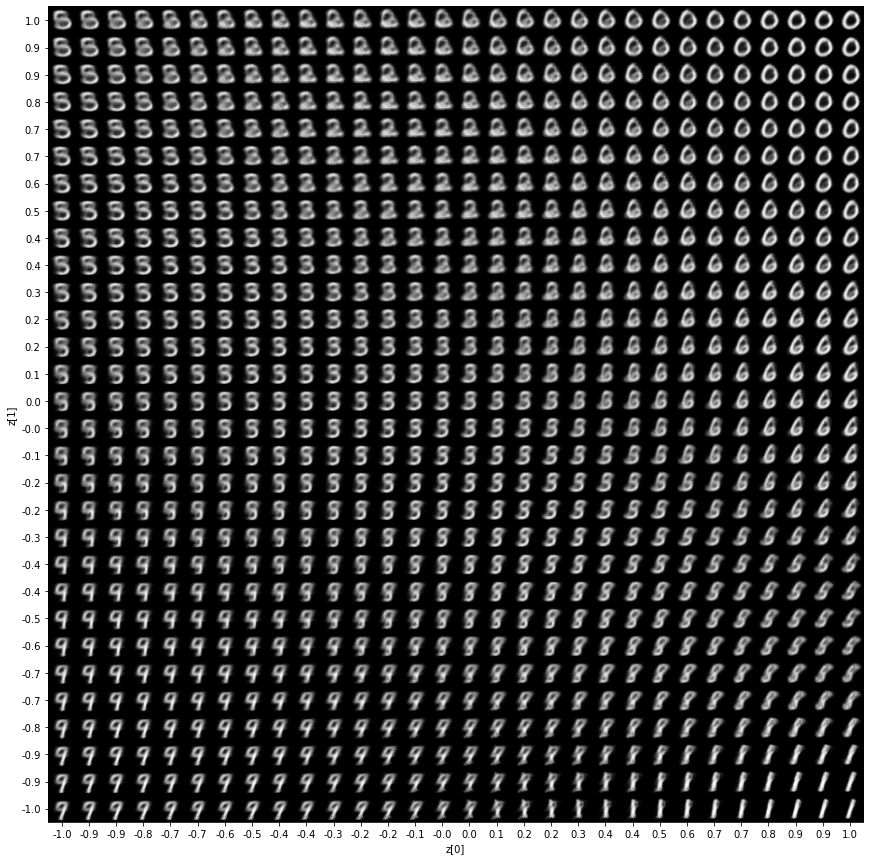

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

## Display how the latent space clusters different digit classes

1875/1875 [==============================] - 5s 3ms/step


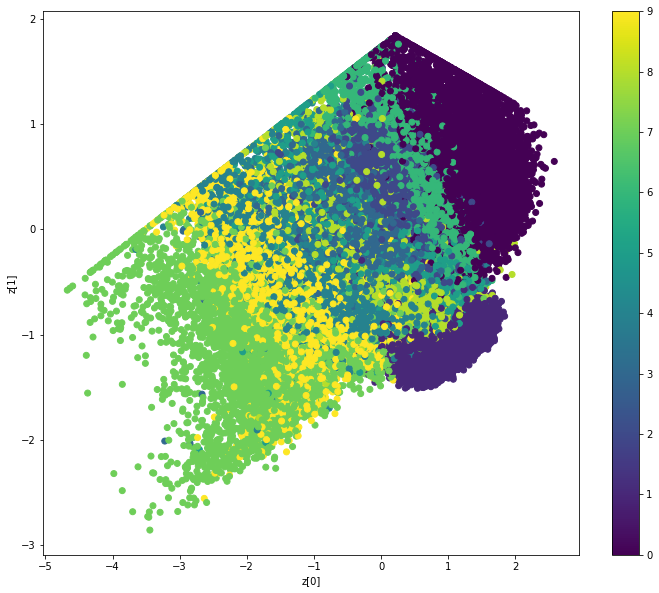

In [ ]:

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)